In [85]:
!pip -q install --upgrade pip
!pip -q install "hmmlearn>=0.3.2"


In [86]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

In [87]:
#load weather data for SPI

weekly_SPI = pd.read_csv("weekly_spi6_weibull_only.csv", parse_dates=["date"]) #important columns: date & SPI_6
weekly_SPI.head()

,date,weekly_precip,precip_6mo,SPI_6
0,1970-07-05,29.633333,554.183333,NaN
1,1970-07-12,2.766667,555.350000,NaN
2,1970-07-19,23.783333,572.083333,NaN
3,1970-07-26,7.066667,576.266667,NaN
4,1970-08-02,27.283333,596.383333,NaN


In [88]:
weekly_SPI = weekly_SPI[weekly_SPI['SPI_6'].notna().cummax()]
weekly_SPI.head()
weekly_SPI["SPI_6_raw"] = weekly_SPI["SPI_6"]
if "date" in weekly_SPI.columns:
    weekly_SPI = weekly_SPI.sort_values("date")
else:
    weekly_SPI = weekly_SPI.sort_index()

weekly_SPI["SPI_6"] = weekly_SPI["SPI_6"].ffill()

In [89]:
nan_per_col = weekly_SPI.isna().sum().sort_values(ascending=False)
print(nan_per_col)

SPI_6_raw        8
date             0
weekly_precip    0
precip_6mo       0
SPI_6            0
dtype: int64


In [90]:
#parse dates - to convert date column into pandas date.time and not leave as text
cutoff = pd.Timestamp('2000-01-01')
weekly_SPI = weekly_SPI[weekly_SPI['date'] < cutoff].reset_index(drop=True)

In [91]:
#creating df with columns date and spi_6 for certain functions
ws = weekly_SPI
if 'date' not in ws.columns:
    ws = ws.reset_index().rename(columns={'index': 'date'})

# keep only date + SPI_6, rename to spi_6, normalize date, sort, reindex
weekly_spi = (
    ws.loc[:, ['date', 'SPI_6']]
      .rename(columns={'SPI_6': 'spi_6'})
      .assign(date=lambda d: pd.to_datetime(d['date']))
      .sort_values('date')
      .reset_index(drop=True)
)

# quick check
print(weekly_spi.head())

        date     spi_6
0 1977-07-10 -0.730887
1 1977-07-17 -0.613230
2 1977-07-24 -0.664102
3 1977-07-31 -0.573376
4 1977-08-07 -0.159588


In [92]:
def array(df,date_col, spi_col):
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)
    return X_all

In [93]:
array(weekly_spi,date_col="date", spi_col="spi_6")

array([[-0.73088734],
       [-0.61322969],
       [-0.66410203],
       ...,
       [-1.17246353],
       [-1.06900271],
       [-1.14314609]])

In [94]:
# =========================
# Configuration of model parameters
# =========================
@dataclass
class HMMCfg:
    K_grid: Tuple[int, ...] = (2,3) # set to (2,3,4) when model runs porperly
    covariance_type: str = "tied"   # shared variance (good when data are limited)
    n_init: int = 5 #can increase but model will be slower
    max_iter: int = 300 #The Expectation–Maximization algorithm runs iteratively until convergence (change in log-likelihood < tolerance) - usually before 300 but just to be safe
    random_state: int = 0

@dataclass
class RunCfg:
    first_block_start: str = "1992-01-05"  # train on dates < this; forecast from this date
    block_years: int = 5                   # retrain cadence
    horizons: Tuple[int, ...] = (1,4)      # forecast horizons in weeks


In [95]:
# =========================
# Helper functions
# =========================
def _bic(ll, n_params, n_obs): # hmmlearn doesnt have an inherent bic score function so we set it up here
    return -2*ll + n_params*np.log(max(n_obs,1))

def _param_count_1d(K:int, cov_type:str)->int: #I need to know how many free parameters your HMM has in order to compute the BIC
    # start (K-1) + trans K*(K-1) + means K + variance params
    base = (K-1) + K*(K-1) + K
    return base + (1 if cov_type == "tied" else K) #because var is fixed in tied but not in diag or full

def reorder_states_by_mean(model: GaussianHMM) -> GaussianHMM:
    """
    Reorder states by ascending mean IN-PLACE.
    Never assign to covars_ when covariance_type='tied'.
    """
    order = np.argsort(model.means_.ravel())

    # Reorder startprob and transmat
    model.startprob_ = model.startprob_[order]
    model.transmat_  = model.transmat_[order][:, order]

    # Reorder means
    model.means_ = model.means_[order]

    # Only per-state covariances should be permuted
    if model.covariance_type in ("full", "diag", "spherical"):
        model.covars_ = model.covars_[order]

    return model





In [96]:
# =========================
# Helper functions pt2
# =========================

def fit_best_hmm_1d(X: np.ndarray, cfg: HMMCfg) -> GaussianHMM:
    """Fit over K_grid, pick best by BIC, reorder states by mean (dry->wet)."""
    X = np.asarray(X).reshape(-1, 1)
    if not np.isfinite(X).all():
        raise ValueError("X contains NaN/Inf")

    best_bic, best_model = np.inf, None
    for K in cfg.K_grid:
        best_ll, best_k = -np.inf, None
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed
            )
            m.fit(X)
            ll = m.score(X)
            if ll > best_ll:
                best_ll, best_k = ll, m

        bic = _bic(best_ll, _param_count_1d(K, cfg.covariance_type), len(X))
        if bic < best_bic:
            best_bic, best_model = bic, best_k

    if best_model is None:
        raise RuntimeError("No successful fits.")

    # ✅ Use the new, in-place reordering (NO underscore)
    return reorder_states_by_mean(best_model)

# in order to get 4 weeks ahead transition prob we need to get a function that calc the trans prob matrix for four weeks in advance
def T_power(T: np.ndarray, h: int) -> np.ndarray:
    return np.linalg.matrix_power(T, h)

def causal_state_probs_at_t(model: GaussianHMM, X_all: np.ndarray, t: int) -> np.ndarray:
    """
    Causal state probabilities at time t using hmmlearn only:
    run predict_proba on the PREFIX X[:t+1] and take the last row.
    (No future observations beyond t are used.)
    """
    post = model.predict_proba(X_all[:t+1])   # (t+1, K)
    return post[-1]                            # (K,)


In [97]:
# =========================
# Main: train-then-freeze, 5y blocks, per-state probs only
# =========================
def hmm_per_state_blockwise(df: pd.DataFrame,#input df with both date and spi
                            date_col="date", spi_col="spi_6",
                            hmm_cfg=HMMCfg(), run_cfg=RunCfg()):
    """
    - Train on dates < first_block_start.
    - For each 5-year block: refit on dates < block start (expanding window),
      then freeze and forecast each week in the block without using future weeks.
    - Output per-state probabilities at each horizon (no aggregates).
    """
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)

    #It'll train on data < block start and forecast within the block
    first_start = pd.Timestamp(run_cfg.first_block_start)
    last_date   = dates.iloc[-1]
    start_year  = first_start.year
    end_year    = last_date.year
    block_starts = [pd.Timestamp(year=y, month=1, day=1)
                    for y in range(start_year, end_year+1, run_cfg.block_years)]

    #Start the output table (will add columns as we go)
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date) # compute the inclusive end date - 5y minus 1 day

        train_mask = dates < b_start
        if train_mask.sum() < 50:
            print(f"Skip block {b_start.date()}–{b_end.date()} (not enough training data).")
            continue
        # fit the best HMM on the training prefix
        X_train = X_all[train_mask.values]
        model   = fit_best_hmm_1d(X_train, hmm_cfg)
        T       = model.transmat_ #transition probability matrix of shape kxk
        K       = model.n_components #number of states

        # prepare output columns before you start filling them with HMM forecast probabilities
        key = (K, tuple(sorted(run_cfg.horizons)))
        if key not in made_cols_for:
            for h in run_cfg.horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        Tpow = {h: T_power(T, h) for h in run_cfg.horizons}

        #row indices to recognize where the current block is
        block_mask = (dates >= b_start) & (dates <= b_end) # true where the observation’s date falls inside the current 5-year block, false otherwise
        idxs = np.where(block_mask)[0] #converts that boolean mask into the actual row indices

        for t in idxs:
            # causal belief at time t from prefix only
            g_t = causal_state_probs_at_t(model, X_all, t)   # (K,)
            for h in run_cfg.horizons:
                g_th = g_t @ Tpow[h]                          # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])

        #block summary in the notebook output
        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={train_mask.sum()}, block_weeks={block_mask.sum()}, K={K}")

    return out


In [98]:
# ===========
# Computing the model - execution
# ===========

results = hmm_per_state_blockwise(
    df = weekly_spi, date_col="date", spi_col="spi_6",
    hmm_cfg=HMMCfg(covariance_type="tied", K_grid=(2,3,4), n_init=5, max_iter=300),
    run_cfg=RunCfg(first_block_start="1992-01-05", block_years=5, horizons=(1,4))
)


Block 1992-01-01–1996-12-31: train_weeks=756, block_weeks=261, K=4
Block 1997-01-01–1999-12-26: train_weeks=1017, block_weeks=156, K=4


In [99]:
#plotting dry period probs

def plot_state0_probs(results: pd.DataFrame, horizons=(1, 4), title="State 0 (driest) probabilities over time"):
    """
    Plots p_state0_h{h} over time for the given horizons.
    Expects columns: 'date', and for each h in horizons, 'p_state0_h{h}'.
    """
    # Ensure datetime & sort
    df = results.copy()
    if 'date' not in df.columns:
        raise ValueError("Expected a 'date' column in results.")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Prepare figure
    plt.figure(figsize=(12, 4))

    # Plot each horizon if present
    plotted_any = False
    for h in horizons:
        col = f"p_state0_h{h}"
        if col in df.columns:
            plt.plot(df['date'], df[col], label=f"h={h}")
            plotted_any = True
        else:
            print(f"[warn] Column '{col}' not found; skipping.")

    if not plotted_any:
        raise ValueError(f"None of the requested horizons found: {horizons}. "
                         f"Available columns: {[c for c in results.columns if c.startswith('p_state0_h')]}")

    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

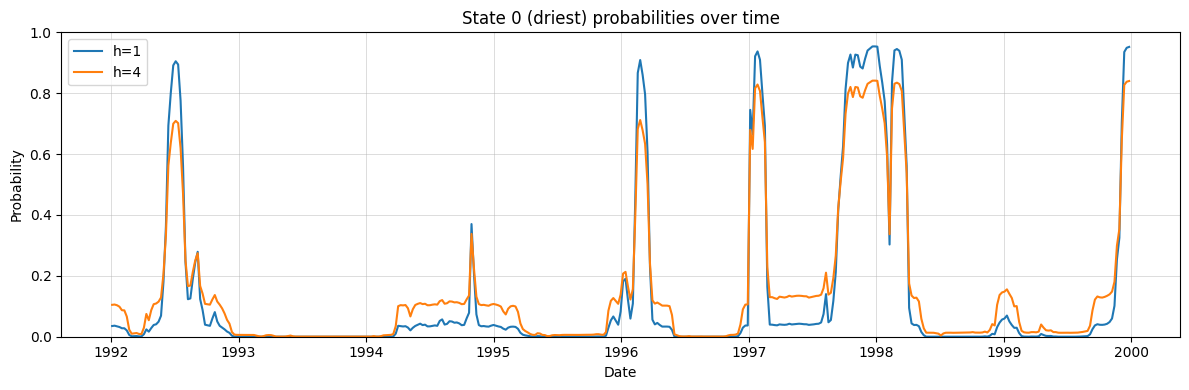

In [100]:
plot_state0_probs(results, horizons=(1, 4))

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_spi_with_bands(
    df: pd.DataFrame,
    date_col: str = "date",
    spi_col: str = "SPI_6",
    title: str = "Standardized Precipitation Index (SPI)",
    start_date: str = "1992-01-01",   # 👈 NEW: filter lower bound
    bands=None,
    show_legend: bool = True,
    annotate_right: bool = True,
    figsize=(12, 5),
    savepath: str | None = None,
):
    """
    Plot SPI over time with horizontal classification bands,
    starting from start_date.
    """

    # --- Prep data
    df = df.copy()
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # Filter from start_date
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        df = df[df[date_col] >= start_date]

    x = df[date_col].to_numpy()
    y = df[spi_col].to_numpy()

    if len(df) == 0:
        raise ValueError(f"No data on or after {start_date}.")

    # Default SPI bands (low, high, label, color)
    if bands is None:
        bands = [
            (-np.inf, -2.0, "Extreme drought (≤ -2.0)",     "#7f0000"),
            (-2.0,    -1.5, "Severe drought [-2.0,-1.5)",   "#b30000"),
            (-1.5,    -1.0, "Moderate drought [-1.5,-1.0)", "#e34a33"),
            (-1.0,     1.0, "Near normal (-1.0,1.0)",       "#f7f7f7"),
            ( 1.0,     1.5, "Moderately wet [1.0,1.5)",     "#a1d99b"),
            ( 1.5,     2.0, "Very wet [1.5,2.0)",           "#31a354"),
            ( 2.0,    np.inf,"Extremely wet (≥ 2.0)",       "#006d2c"),
        ]

    # --- Plot
    fig, ax = plt.subplots(figsize=figsize)

    # Shade bands
    ymin = np.nanmin(y)
    ymax = np.nanmax(y)
    pad = 0.2 * (ymax - ymin if ymax != ymin else 2.0)
    ylo = ymin - pad
    yhi = ymax + pad

    legend_patches = []
    for low, high, label, color in bands:
        lo = low if np.isfinite(low) else ylo
        hi = high if np.isfinite(high) else yhi
        ax.axhspan(lo, hi, facecolor=color, alpha=0.18, edgecolor="none")
        legend_patches.append(Patch(facecolor=color, alpha=0.5, label=label))

        if annotate_right:
            y_mid = ( (lo if np.isfinite(low) else -1) + (hi if np.isfinite(high) else 1) ) / 2.0
            ax.text(
                x.max(), y_mid, label.split(" (")[0],
                va="center", ha="right", fontsize=9, alpha=0.8,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1.5)
            )

    # SPI line
    ax.plot(x, y, lw=1.6, color="steelblue")

    # Zero line
    ax.axhline(0.0, color="k", lw=1.0, alpha=0.7)

    # Style
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(spi_col)
    ax.set_ylim(ylo, yhi)
    ax.grid(alpha=0.3)

    if show_legend:
        ax.legend(handles=legend_patches, loc="upper left", frameon=True, fontsize=8)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


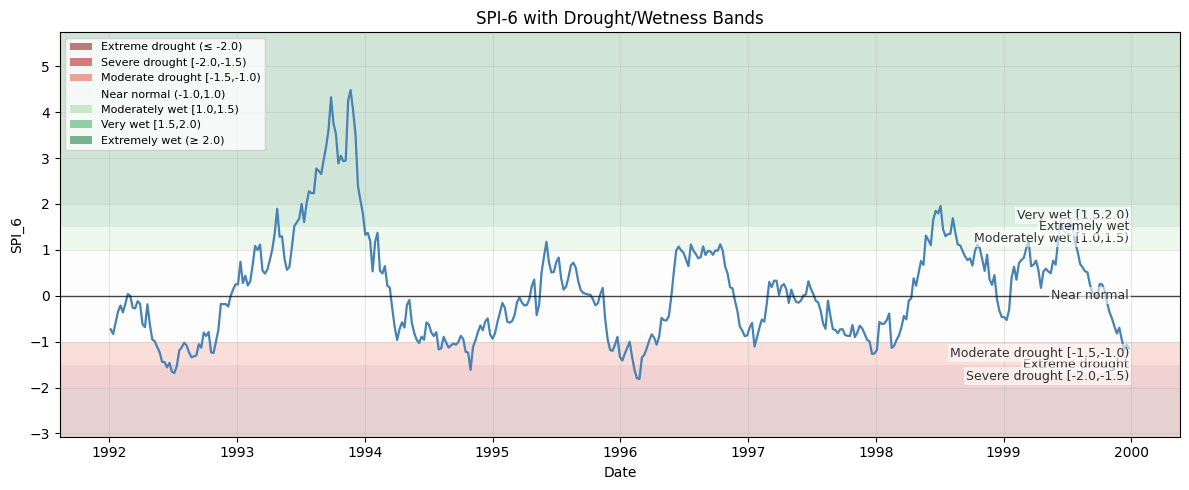

In [108]:
# weekly_SPI: columns ["date", "SPI_6"]
plot_spi_with_bands(weekly_SPI, date_col="date", spi_col="SPI_6",
                    title="SPI-6 with Drought/Wetness Bands")


In [116]:
import pandas as pd
import numpy as np

def spi_prob_lagged_corr(
    results: pd.DataFrame,
    spi_col: str = "spi_6",
    prob_cols: tuple[str, str] = ("p_state0_h1", "p_state0_h4"),
    date_col: str | None = "date",
    start_date: str = "1992-02-01",
    max_lag_weeks: int = 52,
) -> pd.DataFrame:
    """
    Correlate today's SPI with state-0 probabilities from the same day (lag=0)
    and from 1..max_lag_weeks weeks ago.

    Returns a DataFrame with columns:
      lag_weeks, corr_h1, n_h1, corr_h4, n_h4
    """
    df = results.copy()

    # Ensure we have a datetime index/column for filtering and sort by date
    if date_col and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    else:
        # assume index is already datetime-like
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")
        df = df.sort_index()

    # Keep only the needed columns & from start_date
    needed = [spi_col, *prob_cols]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    # Prepare output container
    out_rows = []
    h1, h4 = prob_cols

    # Compute correlations for lags 0..max_lag_weeks
    for lag in range(0, max_lag_weeks + 1):
        # Align: correlate SPI_t with prob_{t - lag}
        prob_h1_lag = df[h1].shift(lag)
        prob_h4_lag = df[h4].shift(lag)

        # Pairwise-drop NaNs per pair
        s_spi = df[spi_col]

        # h1
        mask_h1 = s_spi.notna() & prob_h1_lag.notna()
        corr_h1 = np.nan
        n_h1 = int(mask_h1.sum())
        if n_h1 >= 2:
            corr_h1 = float(s_spi[mask_h1].corr(prob_h1_lag[mask_h1]))

        # h4
        mask_h4 = s_spi.notna() & prob_h4_lag.notna()
        corr_h4 = np.nan
        n_h4 = int(mask_h4.sum())
        if n_h4 >= 2:
            corr_h4 = float(s_spi[mask_h4].corr(prob_h4_lag[mask_h4]))

        out_rows.append({
            "lag_weeks": lag,
            "corr_h1": corr_h1,
            "n_h1": n_h1,
            "corr_h4": corr_h4,
            "n_h4": n_h4,
        })

    out = pd.DataFrame(out_rows).set_index("lag_weeks")
    return out

# ---- usage ----


In [117]:
 corr_table = spi_prob_lagged_corr(results)
 corr_table.head(), corr_table.loc[[0,1,4,12,26,52]]
# If you want the best (most negative/positive) lag quickly:
# best_neg_h1 = corr_table['corr_h1'].idxmin()
# best_pos_h1 = corr_table['corr_h1'].idxmax()
# best_neg_h4 = corr_table['corr_h4'].idxmin()
# best_pos_h4 = corr_table['corr_h4'].idxmax()




(            corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.457302   413 -0.529274   413
 1         -0.431006   412 -0.503033   412
 2         -0.404142   411 -0.475787   411
 3         -0.374247   410 -0.445160   410
 4         -0.347397   409 -0.416403   409,
             corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.457302   413 -0.529274   413
 1         -0.431006   412 -0.503033   412
 4         -0.347397   409 -0.416403   409
 12        -0.162270   401 -0.205763   401
 26         0.164981   387  0.149405   387
 52         0.105337   361  0.125954   361)

In [113]:
results

,date,spi_6,p_state0_h1,p_state1_h1,p_state2_h1,p_state3_h1,p_state0_h4,p_state1_h4,p_state2_h4,p_state3_h4
0,1977-07-10,-0.730887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1977-07-17,-0.613230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1977-07-24,-0.664102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1977-07-31,-0.573376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1977-08-07,-0.159588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1168,1999-11-28,-0.696568,0.325270,0.645402,0.029326,2.352472e-06,0.354021,0.548947,0.093834,0.003198
1169,1999-12-05,-0.950950,0.704585,0.283773,0.011642,2.427077e-07,0.648112,0.307277,0.043250,0.001361
1170,1999-12-12,-1.172464,0.935413,0.063663,0.000924,5.393989e-09,0.827074,0.160183,0.012496,0.000246
1171,1999-12-19,-1.069003,0.949229,0.050488,0.000282,1.007802e-09,0.837786,0.151379,0.010656,0.000180


In [102]:
 #It'll train on data < block start and forecast within the block
  first_start = pd.Timestamp(run_cfg.first_block_start)
  last_date   = dates.iloc[-1]
  start_year  = first_start.year
  end_year    = last_date.year
  block_starts = [pd.Timestamp(year=y, month=1, day=1)
                  for y in range(start_year, end_year+1, run_cfg.block_years)]

    #Start the output table (will add columns as we go)
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date) # compute the inclusive end date - 5y minus 1 day

        train_mask = dates < b_start
        if train_mask.sum() < 50:
            print(f"Skip block {b_start.date()}–{b_end.date()} (not enough training data).")
            continue
        # fit the best HMM on the training prefix
        X_train = X_all[train_mask.values]
        model   = fit_best_hmm_1d(X_train, hmm_cfg)
        T       = model.transmat_ #transition probability matrix of shape kxk
        K       = model.n_components #number of states

        # prepare output columns before you start filling them with HMM forecast probabilities
        key = (K, tuple(sorted(run_cfg.horizons)))
        if key not in made_cols_for:
            for h in run_cfg.horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        Tpow = {h: T_power(T, h) for h in run_cfg.horizons}

        #row indices to recognize where the current block is
        block_mask = (dates >= b_start) & (dates <= b_end) # true where the observation’s date falls inside the current 5-year block, false otherwise
        idxs = np.where(block_mask)[0] #converts that boolean mask into the actual row indices

        for t in idxs:
            # causal belief at time t from prefix only
            g_t = causal_state_probs_at_t(model, X_all, t)   # (K,)
            for h in run_cfg.horizons:
                g_th = g_t @ Tpow[h]                          # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])

        #block summary in the notebook output
        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={train_mask.sum()}, block_weeks={block_mask.sum()}, K={K}")


IndentationError: unexpected indent (ipython-input-911732676.py, line 2)